# Análise de grafo de resultados de jogos da copa do mundo
Neste projeto será realizado uma análise a partir de um dataset com dados sobre resultados de jogos da copa do mundo desde o primeiro campeonato até o ano de 2023.

## Sobre o dataset
O dataset escolhido apresentas as colunas: date,home_team,away_team,home_score,away_score,tournament,city,country,neutral. Este Dataset foi retirado do site Kaggle: https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017. Há resultados para diveros campeonatos de futebol do mundo, no entando a fim de fechar um pouco o escopo do projeto foi analisado apenas os jogos da copa do mundo.

## Modelagem em grafos
Nesta modelagem cada seleção representa um nó, e uma aresta é ligada entre os nós indicando a quantidade de gols (weight) foi marcado por uma seleção em outra (directed edge) em todas as partidas de Copa do mundo. Para efeito de análise, é contabilizado como pontuação (weight) apenas os gols marcados como mandante de campo.

## Instalando dependências

In [2]:
!pip install pyvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 72.2 MB/s eta 0:00:00


## Importando dependências

In [3]:
import numpy as np
import pandas as pd
from pyvis.network import Network
import networkx as nx

Faça o upload do dataset "results.csv" disponibilisado no repositório.

In [5]:
from google.colab import files
uploaded = files.upload()

results = pd.read_csv('results.csv', parse_dates=['date'])

Saving results.csv to results (1).csv


Neste ponto temos o dataset completo retirado do kaggle. Portanto faremos algumas adaptações. Primeiro filtramos apenas partidas da copa do mundo, somamos os resultados das diversas partidas entre dois mesmos times e removemos linhas duplicadas.

In [6]:
#filtra resultados da copa do mundo
results_fifa = results[results['tournament']== 'FIFA World Cup']

#concatena as partidas entre duas equipes (diferenciando por mandante), soma o saldo de gols das partidas e renomeia as colunas
aggregated_data = results_fifa.groupby(['home_team', 'away_team']).agg({'home_score': 'sum', 'away_score': 'sum'}).reset_index()
aggregated_data = aggregated_data.rename(columns={'home_score': 'total_home_score', 'away_score': 'total_away_score'})

# Remover as linhas repetidas se houver
aggregated_data = aggregated_data.drop_duplicates(subset=['home_team', 'away_team'])

Agora montaremos um grafo com o NetworkX. Pra isso filtramos todos os home_teams, aways_teams e scores, por montaremos um grafo com as informações coletadas e suas arestas.

In [7]:

# recupera as seleções e gols do mandante do dataset
home_team = list(aggregated_data['home_team'])
away_team = list(aggregated_data['away_team'])
total_home_score = list(aggregated_data['total_home_score'])
all_team = set(home_team).union(set(away_team))

edge_data = zip(home_team, away_team, total_home_score)

#cria um grafo com NetworkX do dataset
network_nx = nx.DiGraph()

#adiciona cada time com um nó
for team in all_team:
    network_nx.add_node(team)
#preenche com as informações das arestas
for edge in edge_data:
    network_nx.add_edge(edge[0], edge[1], weight=edge[2])

Abaixo análise e plotagem do grafico de matriz de adjascência gerado.

RuntimeError: ignored

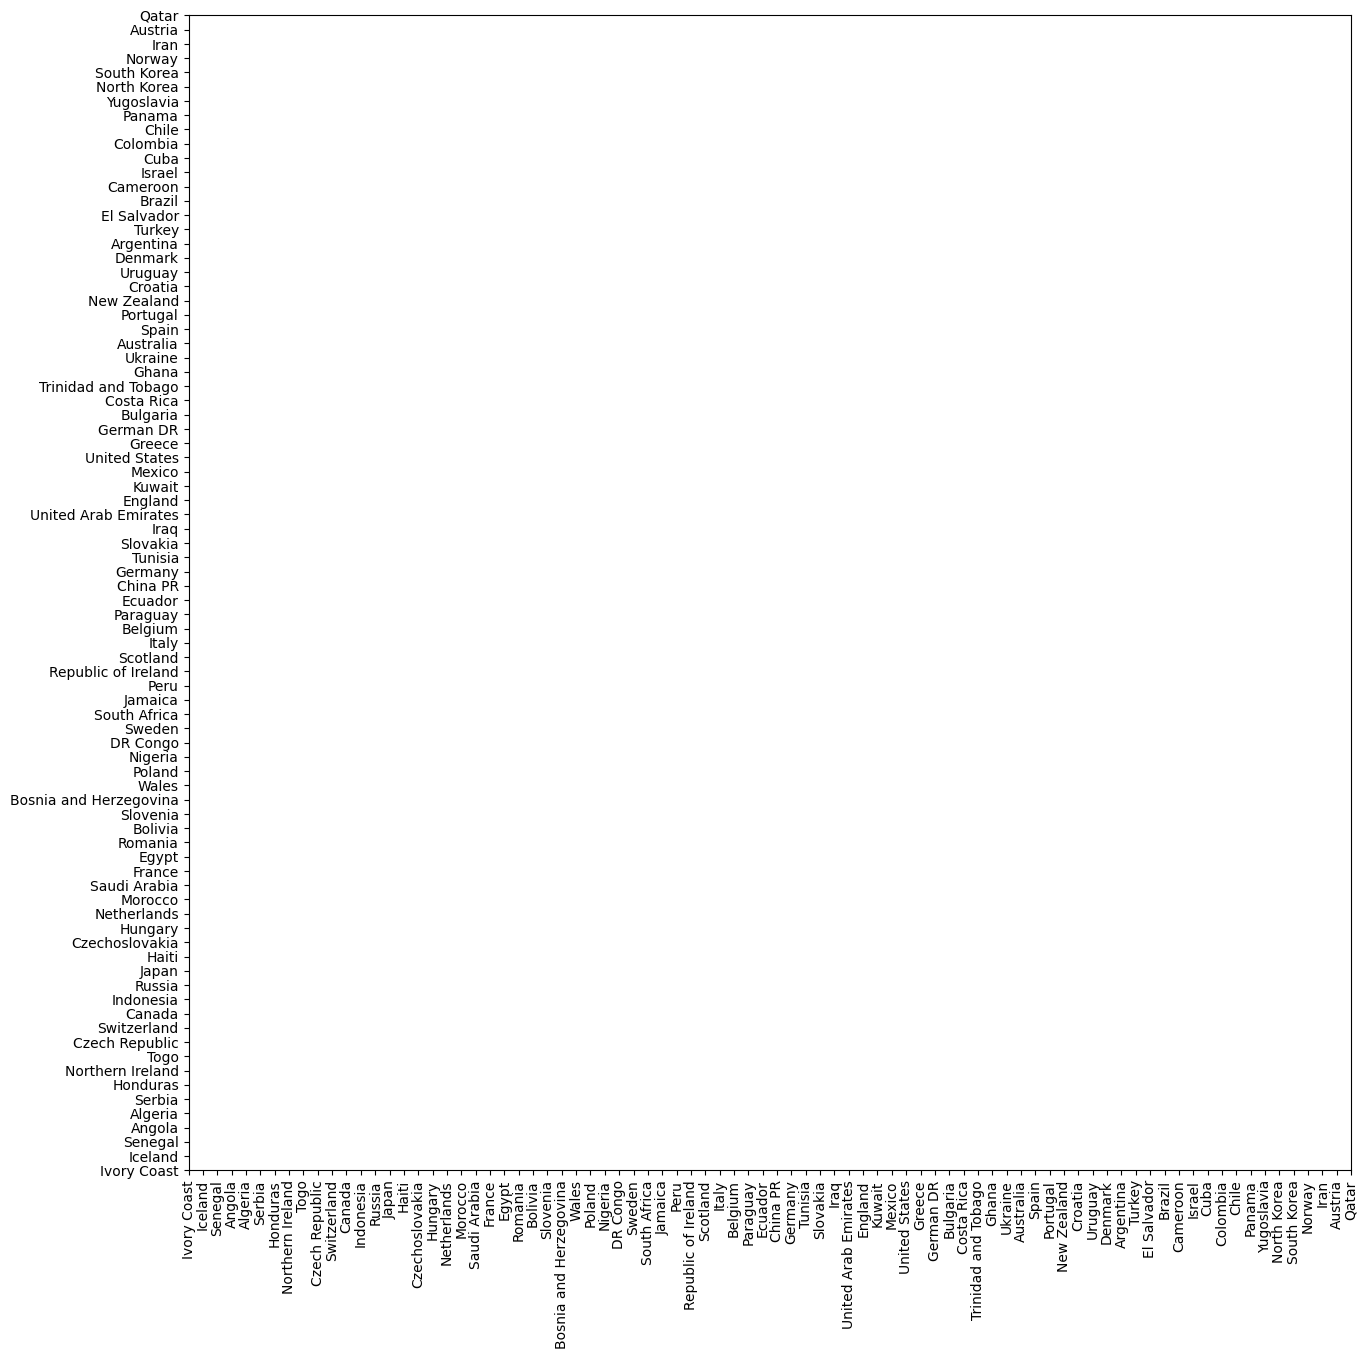

In [52]:
import matplotlib.pyplot as plt
MatrizDeAdjascencia = nx.adjacency_matrix(network_nx)
Matriz_df = pd.DataFrame(MatrizDeAdjascencia.toarray(), index=network_nx.nodes(), columns=network_nx.nodes())

plt_figure = plt.figure(figsize=(15, 15))
plt.xticks(range(len(Matriz_df.columns)), Matriz_df.columns, rotation='vertical')
plt.yticks(range(len(Matriz_df.index)), Matriz_df.index)
plt.colorbar()
plt.show()


Vamos plotar o grafo até aqui produzido

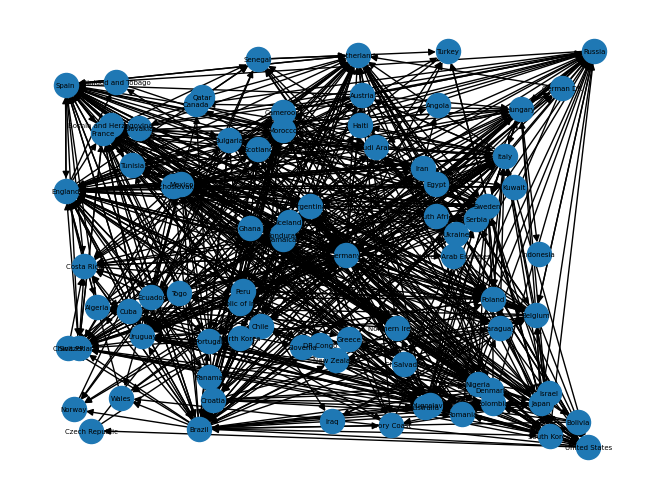

<Figure size 5000x5000 with 0 Axes>

In [31]:
layout = nx.random_layout(network_nx)
nx.draw(network_nx, with_labels=False, pos=layout)
nx.draw_networkx_labels(network_nx, layout, font_size=5)
plt.figure(figsize=(50, 50))
plt.show()

Agora pra demais análises verificaremos se o grafo é fortemente conectado

In [37]:
print("Fortemente conectado: " + str(nx.is_strongly_connected(network_nx)))
componentes = list(nx.strongly_connected_components(network_nx))
for componente in componentes:
  print(componente)

Fortemente conectado: False
{'Indonesia'}
{'Kuwait'}
{'Ivory Coast', 'Iceland', 'Senegal', 'Angola', 'Algeria', 'Serbia', 'Honduras', 'Northern Ireland', 'Togo', 'Czech Republic', 'Switzerland', 'Canada', 'Russia', 'Japan', 'Haiti', 'Czechoslovakia', 'Hungary', 'Netherlands', 'Morocco', 'Saudi Arabia', 'France', 'Egypt', 'Romania', 'Bolivia', 'Slovenia', 'Bosnia and Herzegovina', 'Wales', 'Poland', 'Nigeria', 'DR Congo', 'Sweden', 'South Africa', 'Jamaica', 'Peru', 'Republic of Ireland', 'Scotland', 'Italy', 'Belgium', 'Paraguay', 'Ecuador', 'Germany', 'China PR', 'Tunisia', 'Slovakia', 'Iraq', 'United Arab Emirates', 'England', 'Mexico', 'United States', 'Greece', 'German DR', 'Costa Rica', 'Bulgaria', 'Trinidad and Tobago', 'Ghana', 'Ukraine', 'Australia', 'Spain', 'Portugal', 'New Zealand', 'Croatia', 'Uruguay', 'Denmark', 'Argentina', 'Turkey', 'El Salvador', 'Brazil', 'Cameroon', 'Colombia', 'Chile', 'Panama', 'Yugoslavia', 'North Korea', 'South Korea', 'Norway', 'Iran', 'Austria'

O grafo não é fortemente conectado neste caso isso acontece porque cinco seleções não fizeram gols como mandantes em nenhuma copa do mundo. Portando para as demais análises geraremos um subgrafo com o maior componente fortemente conectado.

In [41]:

subgrafo = network_nx.subgraph(max(nx.strongly_connected_components(network_nx), key=len))
print("Fortemente conectado: " + str(nx.is_strongly_connected(subgrafo)))

print(subgrafo)


Fortemente conectado: True
DiGraph with 77 nodes and 719 edges


Diametro da rede e periferia

In [42]:
try:
    # Calcule o diâmetro do grafo
    diametro = nx.diameter(subgrafo)
    print("Diametro: " + str(diametro))
    # Calcule a períferia do grafo
    periferia = nx.periphery(subgrafo)
    print("Periferia: " + str(periferia))
except:
    print("Devido ao fato do grafo não ser fortemente conectado não é possível calcular diametro e periferia com networkX")


Diametro: 5
Periferia: ['New Zealand', 'Turkey']


Densidade da rede

In [43]:
density = nx.density(subgrafo)
print("Densidade da rede:", density)

Densidade da rede: 0.12286397812713602


É notado uma baixa densidade. O que faz sentido já que em jogos de copa do mundo apenas alguns times jogam contra outros. Durante o campeonato diversas equipes são eliminadas então diminui a probabilidade de haver confrontos entre variadas equipes do torneio.

Assortatividade da rede





In [47]:
assortativity = nx.degree_assortativity_coefficient(subgrafo)
print("Assortatividade da rede:", assortativity)


Assortatividade da rede: -0.09863289942781658


A assortatividade da rede mostra que é uma rede neutra, o que convém com o dataset já que não deve haver relação entre conexões de nós com nós de mesmo grau

 Histograma de distribuição empírica de grau

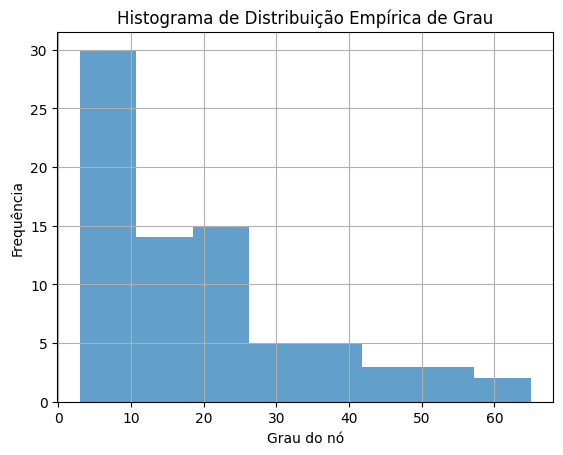

In [48]:
# Calcule a distribuição empírica de grau
degree_sequence = [d for n, d in subgrafo.degree()]

# Crie um histograma da distribuição empírica de grau
plt.hist(degree_sequence, bins='auto', alpha=0.7)
plt.xlabel('Grau do nó')
plt.ylabel('Frequência')
plt.title('Histograma de Distribuição Empírica de Grau')
plt.grid(True)
plt.show()

Coeficiente de clustering global/local

In [54]:
# Calcule o coeficiente de clustering global
print("Coeficiente de clustering global: " + str(nx.average_clustering(subgrafo)))
print()
print("Coeficiente de clustering para Brasil: " + str(nx.clustering(subgrafo, "Brazil")))
print("Coeficiente de clustering para Argentina: " + str(nx.clustering(subgrafo, "Argentina")))
print()
print("Coeficiente de clustering para Angola: " + str(nx.clustering(subgrafo, "Angola")))
print("Coeficiente de clustering para Iceland: " + str(nx.clustering(subgrafo, "Iceland")))
clustering_coefficients = nx.clustering(subgrafo)

# Exiba o coeficiente de clusterização de cada nó
#for node, clustering_coefficient in clustering_coefficients.items():
#    print(f"Coeficiente de clusterização do nó {node}: {clustering_coefficient}")



Coeficiente de clustering global: 0.44284702461026876

Coeficiente de clustering para Brasil: 0.2515479876160991
Coeficiente de clustering para Argentina: 0.2709284627092846

Coeficiente de clustering para Angola: 0.6666666666666666
Coeficiente de clustering para Iceland: 0.6666666666666666


Nós mais importante de acordo com Eigenvector centrality

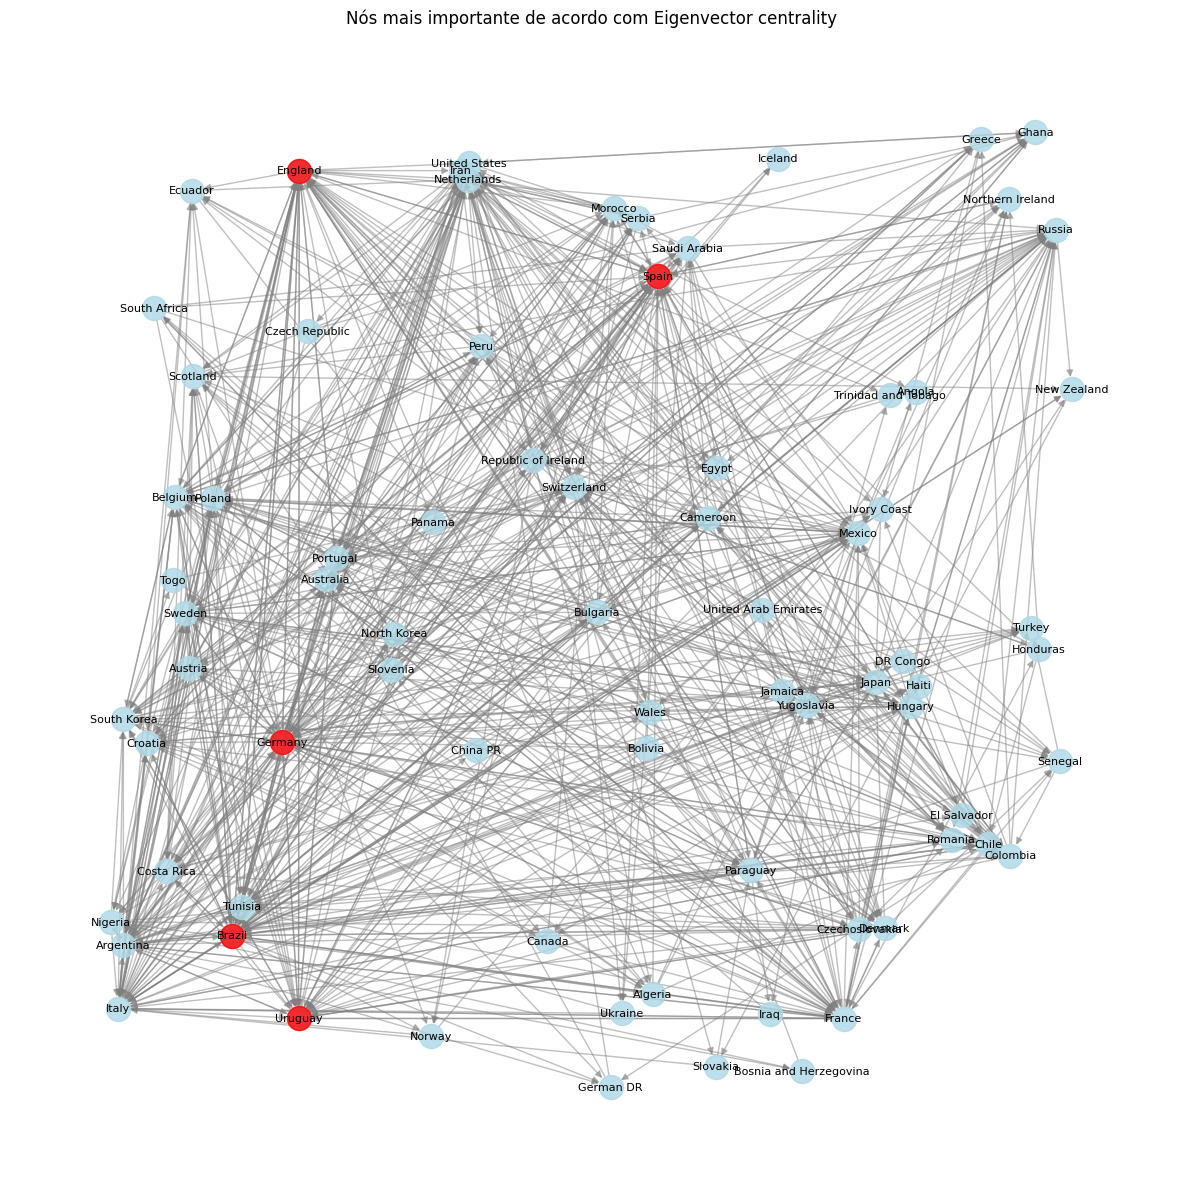

In [62]:
eigenvector_centrality = nx.eigenvector_centrality(subgrafo)
plt.figure(figsize=(15, 15))

# Obtenha os nós mais importantes de acordo com a centralidade de autovetor
important_nodes = sorted(eigenvector_centrality, key=eigenvector_centrality.get, reverse=True)[:5]

# Crie um layout do grafo
pos = nx.random_layout(subgrafo)

# Desenhe os nós e as arestas do grafo
nx.draw_networkx_nodes(subgrafo, pos, node_color='lightblue', alpha=0.8)
nx.draw_networkx_edges(subgrafo, pos, width=1.0, alpha=0.5, edge_color='gray')

# Destaque os nós mais importantes com uma cor diferente
nx.draw_networkx_nodes(subgrafo, pos, nodelist=important_nodes, node_color='red', alpha=0.8, node_size=300)

# Adicione os rótulos dos nós
nx.draw_networkx_labels(subgrafo, pos, font_size=8, font_color='black')

# Exiba o grafo
plt.title('Nós mais importante de acordo com Eigenvector centrality')
plt.axis('off')
plt.show()

Nós mais importante de acordo com degree centrality

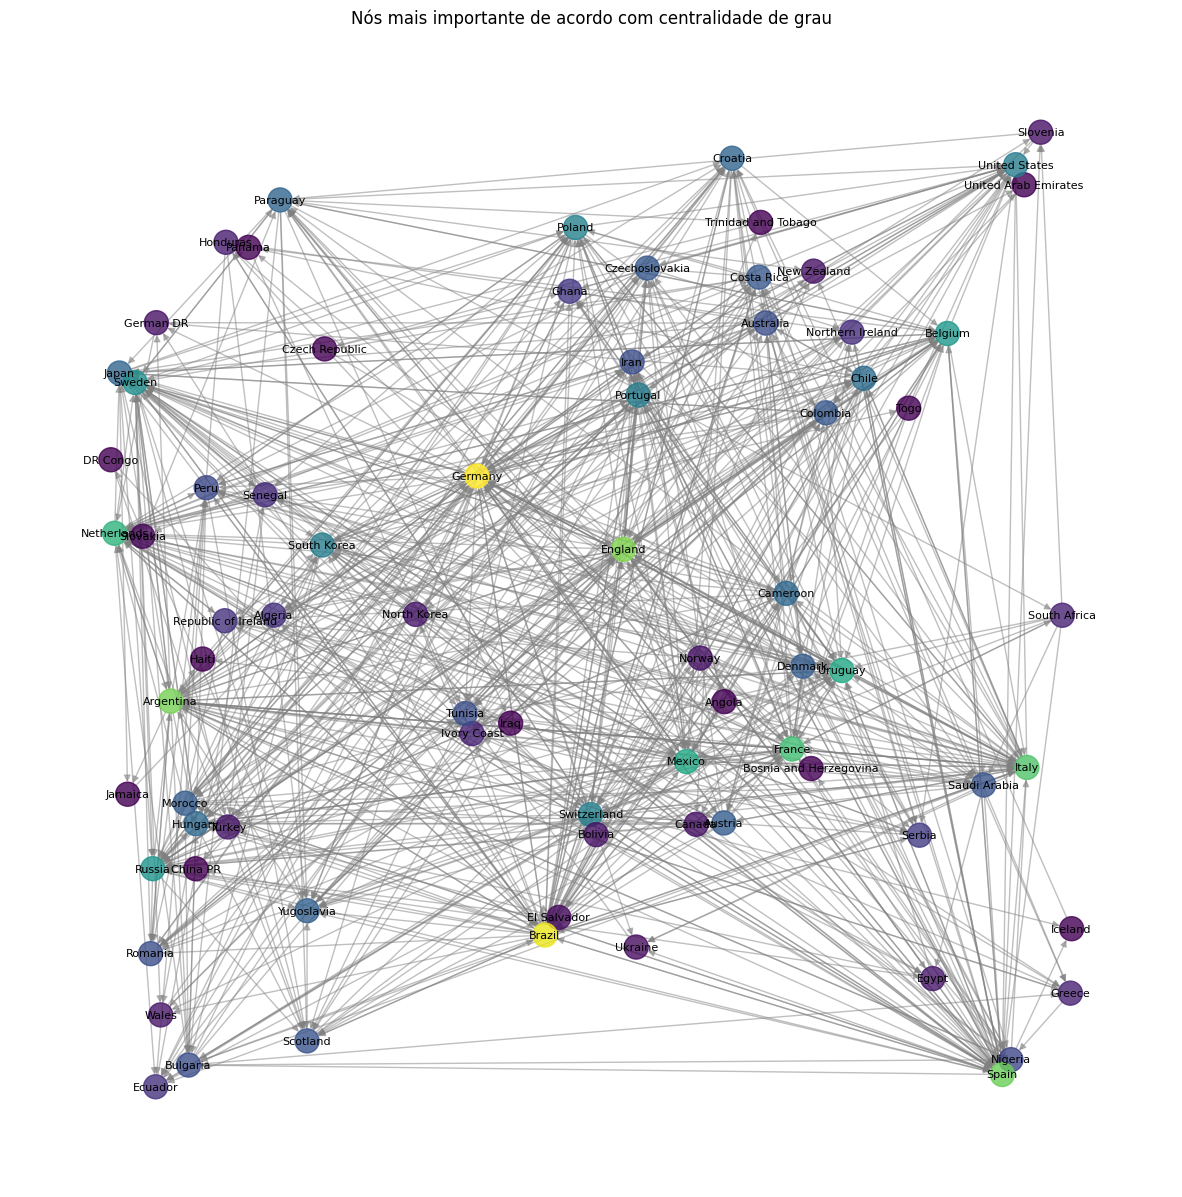

In [77]:
from matplotlib import colors
# Calcule a centralidade de grau
degree_centrality = nx.degree_centrality(subgrafo)
plt.figure(figsize=(15, 15))

# valores de cor pros nós
colors = [degree_centrality[node] for node in subgrafo.nodes()]
#  layout do grafo
pos = nx.random_layout(subgrafo)
nx.draw_networkx_edges(subgrafo, pos, width=1.0, alpha=0.5, edge_color='gray')

# Destaque os nós mais importantes com uma cor diferente
nx.draw_networkx_nodes(subgrafo, pos, node_color=colors, alpha=0.8, node_size=300)

# mostra os rótulos dos nós
nx.draw_networkx_labels(subgrafo, pos, font_size=8, font_color='black')
plt.title('Nós mais importante de acordo com centralidade de grau')
plt.axis('off')
plt.show()

Nós mais importante de acordo com closeness centrality

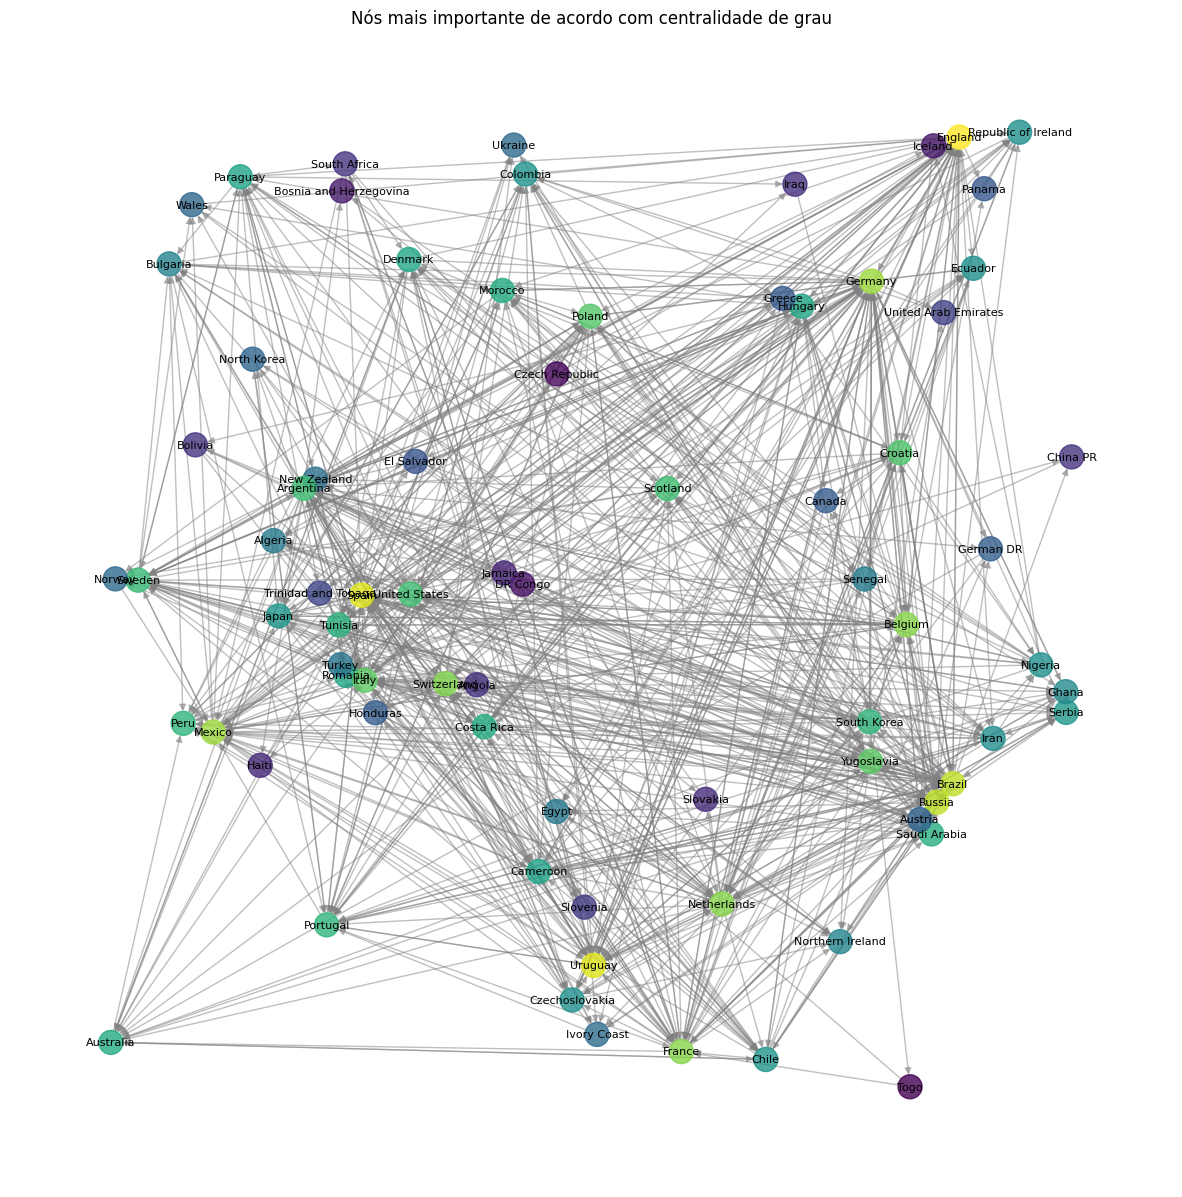

In [69]:
# Calcule a closeness centrality de grau
closeness_centrality = nx.closeness_centrality(subgrafo)
plt.figure(figsize=(15, 15))

# valores de cor pros nós
colors = [closeness_centrality[node] for node in subgrafo.nodes()]
#  layout do grafo
pos = nx.random_layout(subgrafo)
nx.draw_networkx_edges(subgrafo, pos, width=1.0, alpha=0.5, edge_color='gray')

# Destaque os nós mais importantes com uma cor diferente
nx.draw_networkx_nodes(subgrafo, pos, node_color=colors, alpha=0.8, node_size=300)

# mostra os rótulos dos nós
nx.draw_networkx_labels(subgrafo, pos, font_size=8, font_color='black')
plt.title('Nós mais importante de acordo com centralidade de grau')
plt.axis('off')
plt.show()

Nós mais importante de acordo com Betweenness centrality

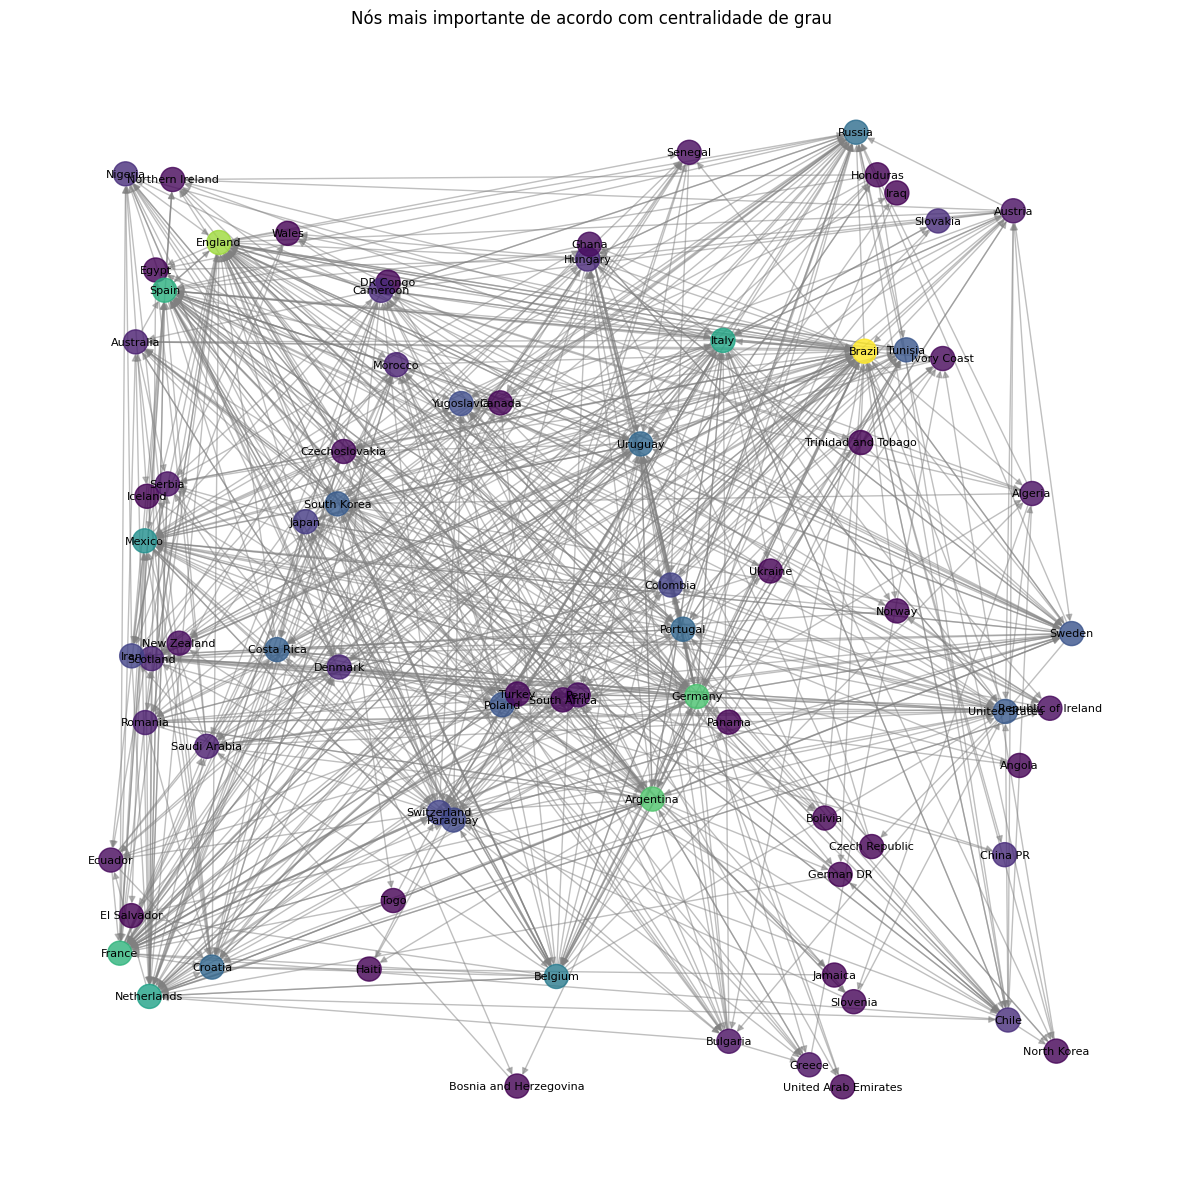

In [70]:
# Calcule a Betweenness centrality de grau
betweenness_centrality = nx.betweenness_centrality(subgrafo)
plt.figure(figsize=(15, 15))

# valores de cor pros nós
colors = [betweenness_centrality[node] for node in subgrafo.nodes()]
#  layout do grafo
pos = nx.random_layout(subgrafo)
nx.draw_networkx_edges(subgrafo, pos, width=1.0, alpha=0.5, edge_color='gray')

# Destaque os nós mais importantes com uma cor diferente
nx.draw_networkx_nodes(subgrafo, pos, node_color=colors, alpha=0.8, node_size=300)

# mostra os rótulos dos nós
nx.draw_networkx_labels(subgrafo, pos, font_size=8, font_color='black')
plt.title('Nós mais importante de acordo com centralidade de grau')
plt.axis('off')
plt.show()